
# CNN workshop
Shahid Beheshti University

Kian Anvari

---



# Import Packages

In [1]:
#importig necessary libraries
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from random import randrange
from skimage.util import random_noise
from tqdm.notebook import tqdm

# Download CIFAR10 dataset

In [3]:
# standard cast into Tensor and pixel values normalization in [-1, 1] range
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [4]:
train_data=datasets.CIFAR10('data',train=True,download=True,transform=transform)
test_data=datasets.CIFAR10('data',train=False,download=True,transform=transform)

100%|██████████| 170498071/170498071 [00:04<00:00, 42421794.90it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


# Prepare data & dataloader

In [5]:
num_workers=2 # number of subprocesses to use for data loading
batch_size=64
valid_size=0.2 # percentage of training set to use as validation

train_length = len(train_data)
indices=list(range(train_length)) # obtain training indices that will be used for validation
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices) # randomly shuffle data indeces

train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler=SubsetRandomSampler(train_idx)
validation_sampler=SubsetRandomSampler(valid_idx)

train_loader=DataLoader(train_data, num_workers=num_workers, batch_size=batch_size, sampler=train_sampler)
validation_loader=DataLoader(train_data, num_workers=num_workers, batch_size=batch_size, sampler=validation_sampler)
test_loader=DataLoader(test_data,shuffle=True, num_workers=num_workers, batch_size=batch_size)

# Visualize some data

In [6]:
image_dataiter = iter(train_loader)
data = next(image_dataiter)
imgs, labels = data

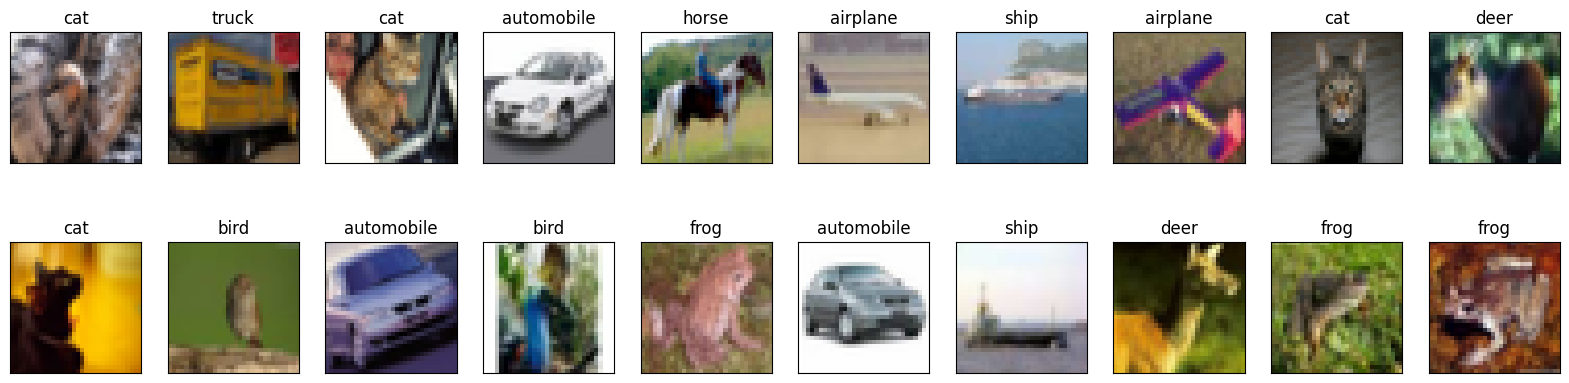

In [7]:
classes=['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def RGBshow(img):
    img=img*0.5+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

fig=plt.figure(1,figsize=(20,5))
for idx in range(20):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    RGBshow(imgs[idx])
    ax.set_title(classes[labels[idx]])

# Define Convolutional Neural Network

Neural Network Architecture

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=128 * 2 * 2, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):

        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = nn.functional.relu(x)

        x = self.conv3(x)
        x = nn.functional.relu(x)

        x = self.conv4(x)
        x = nn.functional.relu(x)

        # flattening
        x = x.view(-1, 128 * 2 * 2)

        # fully connected layers
        x = self.fc1(x)
        x = nn.functional.relu(x)

        x = self.fc2(x)
        x = nn.functional.relu(x)

        x = self.fc3(x)

        return x

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
model = CNN()
model.to(device)

print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


Loss function & optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Train & validation process

In [ ]:
# number of epochs to train the model
n_epochs = 20

#List to store loss to visualize
valid_loss_min = np.Inf # to save the best model with lower validation loss while training process
train_losslist = []
train_acc_list = []
valid_acc_list = []
history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1} ...')
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    train_correct = 0
    valid_correct = 0
    train_total = 0
    valid_total = 0

    # Train
    model.train()
    for data, target in tqdm(train_loader):

        # move tensors to GPU
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        # forward pass
        output = model(data)

        # break

        loss = criterion(output, target)
        # backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)

        # update training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()

    # break

    # Validate
    model.eval()
    for data, target in tqdm(validation_loader):

        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)
        loss = criterion(output, target)

        valid_loss += loss.item()*data.size(0)

        # update validation accuracy
        _, predicted = torch.max(output.data, 1)
        valid_total += target.size(0)
        valid_correct += (predicted == target).sum().item()

    # calculate average losses and accuracy
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(validation_loader.dataset)
    train_acc = 100 * train_correct / train_total
    valid_acc = 100 * valid_correct / valid_total
    train_losslist.append(train_loss)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} - Validation Loss: {:.6f} - Training Accuracy: {:.2f}% - Validation Accuracy: {:.2f}%'.format(
        epoch+1, train_loss, valid_loss, train_acc, valid_acc))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). The new model saved.'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'CNN-1.pt')
        valid_loss_min = valid_loss

    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(valid_acc)


Epoch 1 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.839369 - Validation Loss: 0.459167 - Training Accuracy: 16.52% - Validation Accuracy: 17.63%
Validation loss decreased (inf --> 0.459167). The new model saved.
Epoch 2 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.804444 - Validation Loss: 0.429224 - Training Accuracy: 17.41% - Validation Accuracy: 22.33%
Validation loss decreased (0.459167 --> 0.429224). The new model saved.
Epoch 3 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 1.597913 - Validation Loss: 0.371706 - Training Accuracy: 26.59% - Validation Accuracy: 29.87%
Validation loss decreased (0.429224 --> 0.371706). The new model saved.
Epoch 4 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 1.443709 - Validation Loss: 0.348406 - Training Accuracy: 32.18% - Validation Accuracy: 33.70%
Validation loss decreased (0.371706 --> 0.348406). The new model saved.
Epoch 5 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 1.371382 - Validation Loss: 0.334461 - Training Accuracy: 35.40% - Validation Accuracy: 35.90%
Validation loss decreased (0.348406 --> 0.334461). The new model saved.
Epoch 6 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 1.310323 - Validation Loss: 0.317526 - Training Accuracy: 38.33% - Validation Accuracy: 39.70%
Validation loss decreased (0.334461 --> 0.317526). The new model saved.
Epoch 7 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 1.253787 - Validation Loss: 0.314307 - Training Accuracy: 41.05% - Validation Accuracy: 40.64%
Validation loss decreased (0.317526 --> 0.314307). The new model saved.
Epoch 8 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 1.200368 - Validation Loss: 0.294484 - Training Accuracy: 44.17% - Validation Accuracy: 44.32%
Validation loss decreased (0.314307 --> 0.294484). The new model saved.
Epoch 9 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 1.149447 - Validation Loss: 0.294010 - Training Accuracy: 47.12% - Validation Accuracy: 45.72%
Validation loss decreased (0.294484 --> 0.294010). The new model saved.
Epoch 10 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 1.101137 - Validation Loss: 0.270576 - Training Accuracy: 49.81% - Validation Accuracy: 50.39%
Validation loss decreased (0.294010 --> 0.270576). The new model saved.
Epoch 11 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 1.059437 - Validation Loss: 0.264543 - Training Accuracy: 51.94% - Validation Accuracy: 51.35%
Validation loss decreased (0.270576 --> 0.264543). The new model saved.
Epoch 12 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 1.019456 - Validation Loss: 0.253218 - Training Accuracy: 53.98% - Validation Accuracy: 54.43%
Validation loss decreased (0.264543 --> 0.253218). The new model saved.
Epoch 13 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.985312 - Validation Loss: 0.248151 - Training Accuracy: 55.41% - Validation Accuracy: 55.16%
Validation loss decreased (0.253218 --> 0.248151). The new model saved.
Epoch 14 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.956847 - Validation Loss: 0.237397 - Training Accuracy: 56.74% - Validation Accuracy: 56.73%
Validation loss decreased (0.248151 --> 0.237397). The new model saved.
Epoch 15 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.926095 - Validation Loss: 0.235215 - Training Accuracy: 58.24% - Validation Accuracy: 56.72%
Validation loss decreased (0.237397 --> 0.235215). The new model saved.
Epoch 16 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.897988 - Validation Loss: 0.223908 - Training Accuracy: 59.46% - Validation Accuracy: 59.85%
Validation loss decreased (0.235215 --> 0.223908). The new model saved.
Epoch 17 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.874463 - Validation Loss: 0.226665 - Training Accuracy: 60.81% - Validation Accuracy: 59.36%
Epoch 18 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.847313 - Validation Loss: 0.218561 - Training Accuracy: 62.03% - Validation Accuracy: 60.62%
Validation loss decreased (0.223908 --> 0.218561). The new model saved.
Epoch 19 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.825434 - Validation Loss: 0.229255 - Training Accuracy: 63.13% - Validation Accuracy: 58.97%
Epoch 20 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.799547 - Validation Loss: 0.217941 - Training Accuracy: 64.44% - Validation Accuracy: 61.81%
Validation loss decreased (0.218561 --> 0.217941). The new model saved.


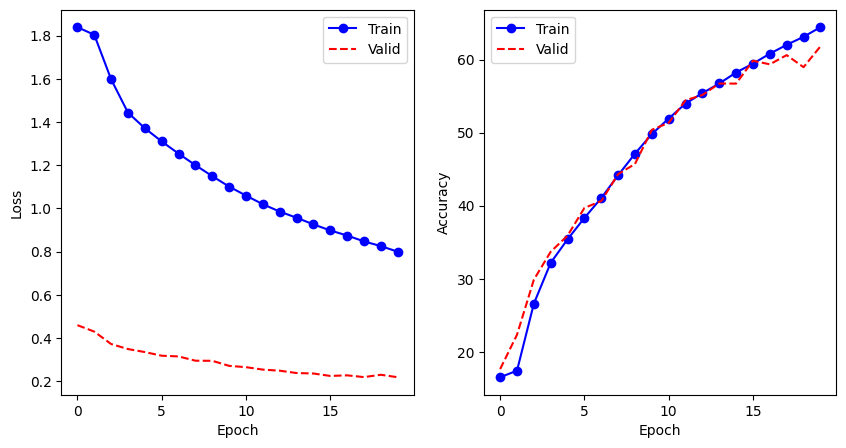

In [ ]:
fig=plt.figure(1,figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], 'bo-', label='Train')
plt.plot(history['valid_loss'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], 'bo-', label='Train')
plt.plot(history['valid_acc'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

Test process

In [ ]:
model.load_state_dict(torch.load('CNN-1.pt'))

<All keys matched successfully>

In [ ]:
# test the model
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for data, target in tqdm(test_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)

        loss = criterion(output, target)

        # update test loss
        test_loss += loss.item()*data.size(0)
        # update test accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

# calculate average test loss and accuracy
test_loss = test_loss/len(test_loader.dataset)
test_acc = 100 * test_correct / test_total

# print test statistics
print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%'.format(test_loss, test_acc))

# add to history
history['test_loss'] = test_loss
history['test_acc'] = test_acc

  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 1.093258 - Test Accuracy: 61.30%


# Optimized Convolutional Neural Network

Neural Network Architecture

In [ ]:
class CNN(nn.Module):

    def __init__(self):

        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):

        # conv layers
        x = self.conv_layer(x)

        # flatten
        x = x.view(x.size(0), -1)

        # fc layer
        x = self.fc_layer(x)

        return x


In [ ]:
model = CNN()
model.cuda()

model

loss function & optimizer

In [ ]:
# specify loss function
criterion = nn.CrossEntropyLoss()

train & validation process

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# number of epochs to train the model
n_epochs = 30
learning_rate = 0.001

#List to store loss to visualize
valid_loss_min = np.Inf
train_losslist = []
train_acc_list = []
valid_acc_list = []
history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1} ...')
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    train_correct = 0
    valid_correct = 0
    train_total = 0
    valid_total = 0

    #Changing the optimizer setting while training
    if epoch <= 10:
      optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif epoch > 10 and epoch <= 25:
      optimizer = optim.Adam(model.parameters(), lr=(learning_rate)/10)
    else:
     optimizer = optim.Adam(model.parameters(), lr=(learning_rate)/50)


    # Train
    model.train()
    for data, target in tqdm(train_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        # forward pass
        output = model(data)

        loss = criterion(output, target)
        # backward pass
        loss.backward()
        optimizer.step()

        # update training loss
        train_loss += loss.item()*data.size(0)
        # update training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()


    #validate
    model.eval()
    for data, target in tqdm(validation_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)

        loss = criterion(output, target)

        # update average validation loss
        valid_loss += loss.item()*data.size(0)
        # update validation accuracy
        _, predicted = torch.max(output.data, 1)
        valid_total += target.size(0)
        valid_correct += (predicted == target).sum().item()

    # calculate average losses and accuracy
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(validation_loader.dataset)
    train_acc = 100 * train_correct / train_total
    valid_acc = 100 * valid_correct / valid_total
    train_losslist.append(train_loss)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} - Validation Loss: {:.6f} - Training Accuracy: {:.2f}% - Validation Accuracy: {:.2f}%'.format(
        epoch+1, train_loss, valid_loss, train_acc, valid_acc))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). The new model saved.'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'CNN-2.pt')
        valid_loss_min = valid_loss

    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(valid_acc)


Epoch 1 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 1.130262 - Validation Loss: 0.248565 - Training Accuracy: 47.83% - Validation Accuracy: 56.19%
Validation loss decreased (inf --> 0.248565). The new model saved.
Epoch 2 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.795483 - Validation Loss: 0.180207 - Training Accuracy: 64.92% - Validation Accuracy: 67.87%
Validation loss decreased (0.248565 --> 0.180207). The new model saved.
Epoch 3 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.650635 - Validation Loss: 0.148574 - Training Accuracy: 71.72% - Validation Accuracy: 74.09%
Validation loss decreased (0.180207 --> 0.148574). The new model saved.
Epoch 4 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.560126 - Validation Loss: 0.175836 - Training Accuracy: 75.86% - Validation Accuracy: 70.66%
Epoch 5 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.493927 - Validation Loss: 0.144093 - Training Accuracy: 78.54% - Validation Accuracy: 75.11%
Validation loss decreased (0.148574 --> 0.144093). The new model saved.
Epoch 6 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.435836 - Validation Loss: 0.132399 - Training Accuracy: 80.96% - Validation Accuracy: 77.25%
Validation loss decreased (0.144093 --> 0.132399). The new model saved.
Epoch 7 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.388193 - Validation Loss: 0.134720 - Training Accuracy: 83.19% - Validation Accuracy: 77.96%
Epoch 8 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.348370 - Validation Loss: 0.122316 - Training Accuracy: 84.83% - Validation Accuracy: 79.74%
Validation loss decreased (0.132399 --> 0.122316). The new model saved.
Epoch 9 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.313809 - Validation Loss: 0.128493 - Training Accuracy: 86.31% - Validation Accuracy: 79.42%
Epoch 10 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.288612 - Validation Loss: 0.128908 - Training Accuracy: 87.42% - Validation Accuracy: 79.58%
Epoch 11 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.263173 - Validation Loss: 0.125852 - Training Accuracy: 88.58% - Validation Accuracy: 80.45%
Epoch 12 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.143331 - Validation Loss: 0.118386 - Training Accuracy: 93.82% - Validation Accuracy: 83.20%
Validation loss decreased (0.122316 --> 0.118386). The new model saved.
Epoch 13 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.107853 - Validation Loss: 0.124536 - Training Accuracy: 95.17% - Validation Accuracy: 83.41%
Epoch 14 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.093790 - Validation Loss: 0.132827 - Training Accuracy: 95.72% - Validation Accuracy: 83.86%
Epoch 15 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.083559 - Validation Loss: 0.134992 - Training Accuracy: 96.33% - Validation Accuracy: 83.67%
Epoch 16 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.074488 - Validation Loss: 0.139696 - Training Accuracy: 96.67% - Validation Accuracy: 83.53%
Epoch 17 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.069847 - Validation Loss: 0.141889 - Training Accuracy: 96.92% - Validation Accuracy: 83.56%
Epoch 18 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.062310 - Validation Loss: 0.146664 - Training Accuracy: 97.18% - Validation Accuracy: 83.79%
Epoch 19 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.058140 - Validation Loss: 0.150409 - Training Accuracy: 97.47% - Validation Accuracy: 83.73%
Epoch 20 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.053536 - Validation Loss: 0.157780 - Training Accuracy: 97.66% - Validation Accuracy: 83.67%
Epoch 21 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.051786 - Validation Loss: 0.161694 - Training Accuracy: 97.67% - Validation Accuracy: 83.56%
Epoch 22 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.043223 - Validation Loss: 0.164638 - Training Accuracy: 98.08% - Validation Accuracy: 83.82%
Epoch 23 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.044249 - Validation Loss: 0.167611 - Training Accuracy: 98.05% - Validation Accuracy: 83.73%
Epoch 24 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.042232 - Validation Loss: 0.172675 - Training Accuracy: 98.21% - Validation Accuracy: 83.26%
Epoch 25 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.038466 - Validation Loss: 0.173720 - Training Accuracy: 98.35% - Validation Accuracy: 83.54%
Epoch 26 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 0.035664 - Validation Loss: 0.187374 - Training Accuracy: 98.48% - Validation Accuracy: 83.21%
Epoch 27 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 0.031758 - Validation Loss: 0.182503 - Training Accuracy: 98.69% - Validation Accuracy: 83.75%
Epoch 28 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 0.028649 - Validation Loss: 0.186226 - Training Accuracy: 98.81% - Validation Accuracy: 83.75%
Epoch 29 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 0.026689 - Validation Loss: 0.188573 - Training Accuracy: 98.86% - Validation Accuracy: 83.86%
Epoch 30 ...


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 0.024923 - Validation Loss: 0.192259 - Training Accuracy: 98.95% - Validation Accuracy: 83.82%


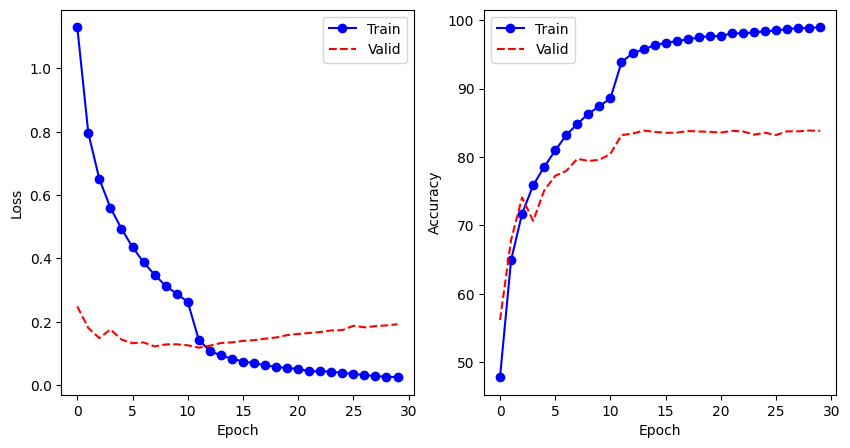

In [ ]:
fig=plt.figure(1,figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], 'bo-', label='Train')
plt.plot(history['valid_loss'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], 'bo-', label='Train')
plt.plot(history['valid_acc'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

test process

In [ ]:
model.load_state_dict(torch.load('CNN-2.pt'))

# test the model
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for data, target in tqdm(test_loader):
        # move tensors to GPU if CUDA is available
        data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss
        test_loss += loss.item()*data.size(0)
        # update test accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

# calculate average test loss and accuracy
test_loss = test_loss/len(test_loader.dataset)
test_acc = 100 * test_correct / test_total

# print test statistics
print('Test Loss: {:.6f} - Test Accuracy: {:.2f}%'.format(test_loss, test_acc))

# add to history
history['test_loss'] = test_loss
history['test_acc'] = test_acc

  0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.622011 - Test Accuracy: 83.34%


# Transfer Learning method

In [ ]:
import torchvision.models as models

In [ ]:
class EnhancedNet(nn.Module):
    def __init__(self):
        super(EnhancedNet, self).__init__()

        # Load pre-trained ResNet50 model
        self.resnet = models.resnet50(pretrained=True)

        # Modify the last layer for our classification task
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)

    def forward(self, x):
        x = self.resnet(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = EnhancedNet().to(device)

criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(net.parameters())

In [ ]:
train_acc = []
train_loss = []
val_acc = []
val_loss = []

net = net.to('cuda')
num_epochs = 8
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Validation
    val_loss1 = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in validation_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss1 += loss.item()

            # compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    train_acc1 = correct / total
    val_acc1 = val_correct / val_total
    train_acc.append(train_acc1)
    train_loss.append(running_loss/len(train_loader))
    val_acc.append(val_acc1)
    val_loss.append(val_loss1/len(validation_loader))
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {running_loss/len(train_loader):.3f}, Training Accuracy: {100 * train_acc1:.2f}%, Validation Loss: {val_loss1/len(validation_loader):.3f}, Validation Accuracy: {100 * val_acc1:.2f}%")

print("Finished training")


Epoch 1/8, Training Loss: 1.173, Training Accuracy: 60.98%, Validation Loss: 1.258, Validation Accuracy: 59.74%
Epoch 2/8, Training Loss: 0.887, Training Accuracy: 70.50%, Validation Loss: 0.776, Validation Accuracy: 74.00%
Epoch 3/8, Training Loss: 0.636, Training Accuracy: 78.64%, Validation Loss: 0.889, Validation Accuracy: 72.92%
Epoch 4/8, Training Loss: 0.514, Training Accuracy: 82.56%, Validation Loss: 0.623, Validation Accuracy: 79.47%
Epoch 5/8, Training Loss: 0.490, Training Accuracy: 83.81%, Validation Loss: 0.920, Validation Accuracy: 70.38%
Epoch 6/8, Training Loss: 0.685, Training Accuracy: 77.47%, Validation Loss: 0.676, Validation Accuracy: 77.35%
Epoch 7/8, Training Loss: 0.366, Training Accuracy: 87.53%, Validation Loss: 0.787, Validation Accuracy: 75.75%
Epoch 8/8, Training Loss: 0.303, Training Accuracy: 89.69%, Validation Loss: 0.657, Validation Accuracy: 80.76%
Finished training


In [ ]:
history = {'loss': train_loss, 'val_loss': val_loss, 'acc':train_acc, 'val_acc':val_acc}

Text(0.5, 1.0, 'Accuracy Evolution')

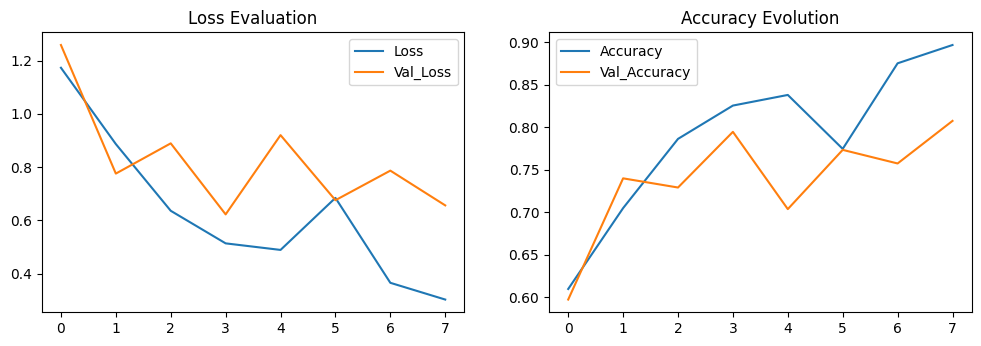

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(history['loss'], label='Loss')
plt.plot(history['val_loss'],label='Val_Loss')
plt.legend()
plt.title('Loss Evaluation')

plt.subplot(2,2,2)
plt.plot(history['acc'], label='Accuracy')
plt.plot(history['val_acc'],label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
# Testing
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device) # pass tensors to device
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")

Accuracy of the network on the 10000 test images: 79.83%
